In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

False
0


AssertionError: Torch not compiled with CUDA enabled

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


In [3]:
# data_dir = '../../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [4]:
transform_characteristics = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

The dataloader is compoosed of 6 batches, each of them of size 32 making a total of: 192, which is enough for storing the 179 images that we have in the positive dataset

In [5]:
print(len(dataloader))

6


In [6]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.0118) tensor(1.)


The problem with the above is that we expected the min value to be 0 according to a previous example.

Converting the images to numpy to be able to show them

In [7]:
imgs = images.detach().numpy()
# imgs = images.numpy()     #We could also use this command to convert it to numpy array. Not sure about the differences
print(type(imgs))

<class 'numpy.ndarray'>


In [8]:
single_img = imgs[0]
img_to_show = single_img * 255
img_to_show = img_to_show.astype("uint8")
one_channel_img = img_to_show[0]
new_img_to_show = np.dstack((one_channel_img, one_channel_img, one_channel_img))

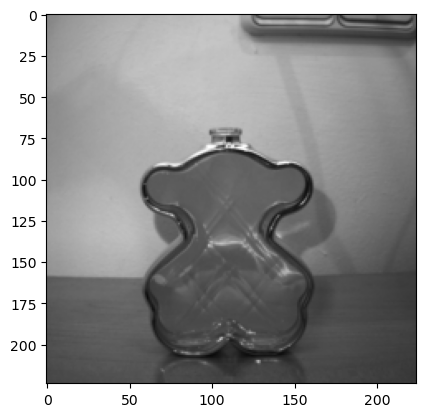

In [9]:
plt.imshow(new_img_to_show)

In [10]:
print(images.shape)

torch.Size([32, 3, 224, 224])


In [12]:
print(images.shape[2])

224


In [13]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        # 32, 3, 224, 224
        input_channels = 3              # number of channels of the input image
        output_channels = 110           # ~= 224/2. Shape of the input image 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        
        output_channels_layer2 = output_channels*2+5

        output_channels_layer3 = output_channels_layer2*2
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val),         # input image channels, output channels, kernel size (filter)
            nn.ReLU(),
            nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val), 
            nn.ReLU(),
            nn.Conv2d(output_channels_layer2, output_channels_layer3, 8) # -> N, 450, 1, 1
        )
        
        # N , 450, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(output_channels_layer3, output_channels_layer2, 8), 
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels_layer2, output_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels, input_channels, kernel_size, stride=2, padding=1, output_padding=1), # N, 3, 224, 224
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

In [14]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [ ]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in dataloader:
        
        # Forward pass
        recon = model(img)
        loss = criterion(recon, img)

        # Backward and optimize
        optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensor s to zero.
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))